### Calculamos los embeddings de las imagenes a insertar

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from typing import List


class ClipEmbeddingsGenerator:
    """
    Class for generating embeddings for images and texts using CLIP model.
    """

    def __init__(self) -> None:
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(self.device)
        self.processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    def embedd_images(self, images_paths: List[str]) -> np.array:
        """
        Embedds images using CLIP model.
        :param images_paths: list of paths to images
        :return: embeddings of images
        """
        images = [Image.open(path) for path in images_paths]
        inputs = self.processor(images=images, return_tensors="pt", text=None).to(self.device)
        outputs = self.model.get_image_features(**inputs)
        return outputs.cpu().detach().numpy()
    
    def embedd_texts(self, texts: List[str]) -> np.array:
        """
        Embedds texts using CLIP model.
        :param texts: list of image descriptions
        :return: embeddings of texts
        """
        inputs = self.processor(images=None, return_tensors="pt", text=texts).to(self.device)
        outputs = self.model.get_text_features(**inputs)
        return outputs.detach().cpu().numpy()

def draw_images(images_paths: List[str], titles: List[str]) -> None:
    """
    Draws images.
    :param images_paths: list of paths to images
    :param titles: list of titles for images
    """
    images = [mpimg.imread(path) for path in images_paths]

    if len(images_paths) == 1:
        plt.figure(figsize=(10, 5))
        plt.imshow(images[0])
        plt.title(titles[0])
        plt.axis("off")
    else:    
        _, axs = plt.subplots(1, len(images), figsize=(10, 5*len(images)))
        for i, (image, title) in enumerate(zip(images, titles)):
            axs[i].imshow(image)
            axs[i].set_title(title)
            axs[i].set_axis_off()

In [2]:
import glob
imgs_paths = glob.glob("avatar_portraits/2024-01-10/*")


# Número de imágenes por lote
batch_size = 1
array_np = []
# Dividir los paths en lotes de tamaño batch_size
img_batches = np.array_split(imgs_paths, len(imgs_paths) // batch_size)

for img_batch in img_batches:
    imgs_embeddings = ClipEmbeddingsGenerator().embedd_images(imgs_paths)
    array_np.append(imgs_embeddings)
    
print("Vector de ejemplo de imagen:", imgs_embeddings[0][:5])



Vector de ejemplo de imagen: [-1.64384142e-01  3.04856330e-01 -2.33876675e-01  1.20763533e-01
 -2.45107368e-01 -3.99337500e-01  2.05166675e-02  3.77282798e-02
  9.08114240e-02  1.05804309e-01  2.88652122e-01  8.45319331e-02
  1.60961136e-01 -7.80647099e-02  3.57011735e-01 -2.08873838e-01
  9.18523192e-01 -3.69506240e-01 -2.75411636e-01  1.66655689e-01
 -3.09530079e-01 -8.40630606e-02 -2.93829888e-01  1.39205188e-01
 -4.04143214e-01  2.32456848e-01  2.11100087e-01  6.87465072e-02
 -6.70804977e-02  2.59161085e-01 -3.88904572e-01  2.34270275e-01
 -8.10545534e-02 -1.12583622e-01  2.20698133e-01  3.83435249e-01
 -5.39257005e-02  6.25972748e-01  1.37865201e-01  3.83311450e-01
  3.77903223e-01  3.84218991e-01  1.54264659e-01 -1.69353724e-01
  3.13643992e-01  1.44338191e+00 -1.03776622e+00  1.12202466e-02
 -3.96251917e-01  2.18280658e-01 -2.69172907e-01  6.25856519e-01
  3.21458042e-01  2.16797233e-01 -6.83065653e-01 -2.61212111e-01
  6.90864399e-02 -4.19517636e-01 -7.56994486e-02  2.60681957e

In [8]:
np.savetxt("imgs_embeddings.csv", imgs_embeddings, delimiter=";")

### Creamos y configuramos la base datos

In [28]:
from pymilvus import MilvusClient, DataType

client = MilvusClient(
    uri="http://localhost:19530"
)

In [39]:
schema = MilvusClient.create_schema(
    auto_id=False,
    enable_dynamic_field=True,
)

# 3.2. Add fields to schema
schema.add_field(field_name="id", datatype=DataType.INT64, is_primary=True)
schema.add_field(field_name="vector", datatype=DataType.FLOAT_VECTOR, dim=512)
schema.add_field(field_name="image_path", datatype=DataType.VARCHAR, max_length=256)


index_params = client.prepare_index_params()
index_params.add_index(
    field_name="id"
)
index_params.add_index(
    field_name="vector", 
    index_type="AUTOINDEX",
    metric_type="COSINE"
)
index_params.add_index(
    field_name="image_path"
)
client.create_collection(
    collection_name="portrait_recommender_3",
    schema=schema,
    index_params=index_params
)

In [44]:
import pandas as pd

embeddings = pd.read_csv("imgs_embeddings.csv", delimiter=";", header=None)

data = [{"id": idx, "vector": emb, "image_path": path} for idx, emb, path in zip(range(len(embeddings)), embeddings.values, imgs_paths)]

In [45]:
res = client.insert(collection_name="portrait_recommender_3", data=data)
print(res)

{'insert_count': 229, 'ids': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 

### vamos a hacer la busqueda


### Creacion de funcion de busqueda de images y/o texto

In [89]:
# vamos a crear una funcion que nos devuelva las images y sus embeddings
def queries_images(imgs_paths: List[str], limit: int) -> List[str]:
    new_img_embedding = ClipEmbeddingsGenerator().embedd_images([imgs_paths])
    found_portraits = client.search(
        collection_name="portrait_recommender_3",
        data=new_img_embedding,
        limit=limit,
        search_params={"metric_type": "COSINE", "params": {}}
    )
    
    ids = [portrait["id"] for portrait in found_portraits[0]]
    
    res = client.get(
    collection_name="portrait_recommender_3",
    ids=ids,
    output_fields=["image_path"]
    )
    
    draw_images([result["image_path"] for result in res], [f"ID: {id}" for id in ids])
    
    return found_portraits

def queries_texts(texts: List[str], limit: int) -> List[str]:
    new_text_embedding = ClipEmbeddingsGenerator().embedd_texts([texts])
    found_portraits = client.search(
        collection_name="portrait_recommender_3",
        data=new_text_embedding,
        limit=limit,
        search_params={"metric_type": "COSINE", "params": {}}
    )
    
    ids = [portrait["id"] for portrait in found_portraits[0]]
    
    res = client.get(
    collection_name="portrait_recommender_3",
    ids=ids,
    output_fields=["image_path"]
    )
    
    draw_images([result["image_path"] for result in res], [f"ID: {id}" for id in ids])
    
    return found_portraits

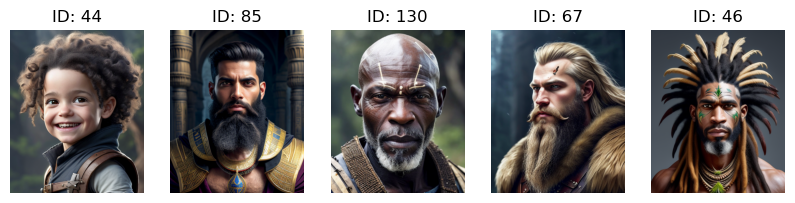

In [94]:
# vamosa hacer un ejemplo de busqueda por imagen
img_path = "./lebron.png"
found_portraits = queries_images(img_path, 5)

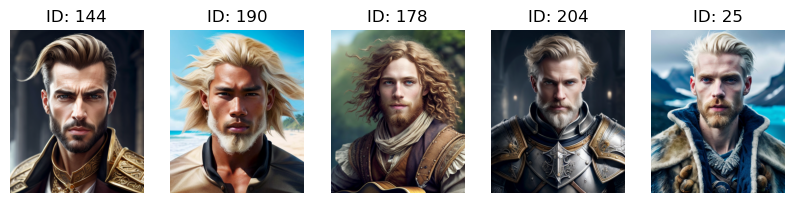

In [91]:
# vamos a hacer un ejemplo de busqueda por texto
text_query = "A portrait of blond men"
found_portraits = queries_texts(text_query, 5)